<a href="https://colab.research.google.com/github/MaxMatteucci/mgmt467-analytics-portfolio/blob/main/Unit3_3_opensky_ps_bqml_with_prompts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook implements a streaming architecture:

Producer: Fetches live data from OpenSky and publishes it to a Google Cloud Pub/Sub Topic.

Consumer: Pulls messages from the Pub/Sub Subscription, streams them into a new BigQuery table (realtime_flight_data), and immediately runs predictions using your existing BQML models.

## 1. Setup and Authentication

Context: Installs necessary Google Cloud libraries and handles Colab authentication.

Prompt: "Write a Python code block for Google Colab that performs the following:

Installs the google-cloud-pubsub, google-cloud-bigquery, google-cloud-storage, and requests libraries via pip.

Imports auth from google.colab and authenticates the user to the Google Cloud environment."

In [ ]:
# Install required packages
# !pip install google-cloud-pubsub google-cloud-bigquery google-cloud-storage requests

from google.colab import auth
print("Authenticating to Google Cloud...")
auth.authenticate_user()
print("Authentication successful.")

Authenticating to Google Cloud...
Authentication successful.


## Cell 2: Configuration Variables

Context: Defines global variables for Project ID, Pub/Sub resources, and BigQuery resources.

Prompt: "Create a configuration cell that defines Python variables for a Google Cloud project. Specifically, define:

PROJECT_ID (e.g., 'mgmt-467-47888')

REGION (e.g., 'us-central1')

TOPIC_NAME (e.g., 'opensky-realtime-topic')

SUBSCRIPTION_NAME (e.g., 'opensky-realtime-sub')

BQ_DATASET (e.g., 'training_dataset')

BQ_TABLE_REALTIME (e.g., 'realtime_flight_data')

MODEL_NAME (e.g., 'flight_velocity_predictor')

Finally, execute a shell command to set the gcloud config project to the defined PROJECT_ID."

In [ ]:
# --- Configuration ---

# Your actual Google Cloud project
PROJECT_ID = "database-project-467"
REGION = "us-central1"

# Pub/Sub Configuration for Unit 3.3
TOPIC_NAME = "opensky-realtime-topic"
SUBSCRIPTION_NAME = "opensky-realtime-sub"

# BigQuery Configuration
BQ_DATASET = "training_dataset"
BQ_TABLE_REALTIME = "realtime_flight_data"   # Table for streaming inserts

# Model name used earlier (from Unit 3.2)
MODEL_NAME = "flight_velocity_predictor"

# Set the project for gcloud commands
!gcloud config set project $PROJECT_ID


INFORMATION: Project 'database-project-467' has no 'environment' tag set. Use either 'Production', 'Development', 'Test', or 'Staging'. Add an 'environment' tag using `gcloud resource-manager tags bindings create`.
Updated property [core/project].


## Cell 3: Infrastructure Setup (Idempotent)

Context: Uses Python clients to create the Topic, Subscription, Dataset, and Table if they don't already exist.

Prompt: "Write a Python script using the Google Cloud SDK (google.cloud) to set up infrastructure idempotently. The script should:

Initialize Pub/Sub and BigQuery clients.

Create a Pub/Sub Topic if it doesn't exist.

Create a Pub/Sub Subscription to that topic if it doesn't exist.

Create a BigQuery Dataset if it doesn't exist.

Create a BigQuery Table named realtime_flight_data if it doesn't exist.

Use a schema for the table that includes fields for OpenSky data: icao24 (STRING), callsign (STRING), origin_country (STRING), time_position (INTEGER), longitude (FLOAT), latitude (FLOAT), geo_altitude (FLOAT), on_ground (BOOLEAN), velocity (FLOAT), heading (FLOAT), vertical_rate (FLOAT), and sensor_timestamp (TIMESTAMP). Handle AlreadyExists exceptions gracefully."

In [ ]:
!pip install google-cloud-pubsub --upgrade
!pip install google-cloud-bigquery --upgrade
!pip install google-cloud-core --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 8.5 MB/s eta 0:00:00


In [ ]:
from google.cloud import pubsub_v1, bigquery
from google.api_core.exceptions import NotFound, AlreadyExists

# Initialize clients
publisher_client = pubsub_v1.PublisherClient()
subscriber_client = pubsub_v1.SubscriberClient()
bq_client = bigquery.Client()

# Construct full resource paths
topic_path = publisher_client.topic_path(PROJECT_ID, TOPIC_NAME)
subscription_path = subscriber_client.subscription_path(PROJECT_ID, SUBSCRIPTION_NAME)

# 1. Create Pub/Sub Topic if it doesn't exist
print(f"Checking Pub/Sub Topic: {TOPIC_NAME}...")
try:
    publisher_client.get_topic(request={"topic": topic_path})
    print(f"Topic {TOPIC_NAME} already exists.")
except NotFound:
    try:
        publisher_client.create_topic(request={"name": topic_path})
        print(f"Topic {TOPIC_NAME} created.")
    except AlreadyExists:
        print(f"Topic {TOPIC_NAME} already exists (concurrent creation).")

# 2. Create Pub/Sub Subscription if it doesn't exist
print(f"Checking Pub/Sub Subscription: {SUBSCRIPTION_NAME}...")
try:
    subscriber_client.get_subscription(request={"subscription": subscription_path})
    print(f"Subscription {SUBSCRIPTION_NAME} already exists.")
except NotFound:
    try:
        # The topic must exist before creating a subscription to it
        subscriber_client.create_subscription(
            request={"name": subscription_path, "topic": topic_path}
        )
        print(f"Subscription {SUBSCRIPTION_NAME} created.")
    except AlreadyExists:
        print(f"Subscription {SUBSCRIPTION_NAME} already exists (concurrent creation).")

# 3. Create BigQuery Dataset if it doesn't exist
dataset_id = f"{PROJECT_ID}.{BQ_DATASET}"
dataset = bigquery.Dataset(dataset_id)

print(f"Checking BigQuery Dataset: {BQ_DATASET}...")
try:
    bq_client.get_dataset(dataset_id)
    print(f"Dataset {BQ_DATASET} already exists.")
except NotFound:
    try:
        dataset = bq_client.create_dataset(dataset)
        print(f"Dataset {BQ_DATASET} created.")
    except AlreadyExists:
        print(f"Dataset {BQ_DATASET} already exists (concurrent creation).")

# 4. Create BigQuery Table if it doesn't exist
table_id = f"{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_REALTIME}"

# Define the schema for the realtime_flight_data table
schema = [
    bigquery.SchemaField("icao24", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("callsign", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("origin_country", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("time_position", "INTEGER", mode="NULLABLE"),
    bigquery.SchemaField("last_contact", "INTEGER", mode="NULLABLE"),
    bigquery.SchemaField("longitude", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("latitude", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("baro_altitude", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("geo_altitude", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("on_ground", "BOOLEAN", mode="NULLABLE"),
    bigquery.SchemaField("velocity", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("heading", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("vertical_rate", "FLOAT", mode="NULLABLE"),
    bigquery.SchemaField("squawk", "STRING", mode="NULLABLE"),
    bigquery.SchemaField("spi", "BOOLEAN", mode="NULLABLE"),
    bigquery.SchemaField("position_source", "INTEGER", mode="NULLABLE"),
    bigquery.SchemaField("sensor_timestamp", "TIMESTAMP", mode="NULLABLE"), # Timestamp for when the data was processed
]

table = bigquery.Table(table_id, schema=schema)

print(f"Checking BigQuery Table: {BQ_TABLE_REALTIME}...")
try:
    bq_client.get_table(table_id)
    print(f"Table {BQ_TABLE_REALTIME} already exists.")
except NotFound:
    try:
        table = bq_client.create_table(table)
        print(f"Table {BQ_TABLE_REALTIME} created.")
    except AlreadyExists:
        print(f"Table {BQ_TABLE_REALTIME} already exists (concurrent creation).")

print("All required Google Cloud resources are ready.")

Checking Pub/Sub Topic: opensky-realtime-topic...
Topic opensky-realtime-topic created.
Checking Pub/Sub Subscription: opensky-realtime-sub...
Subscription opensky-realtime-sub created.
Checking BigQuery Dataset: training_dataset...
Dataset training_dataset already exists.
Checking BigQuery Table: realtime_flight_data...
Table realtime_flight_data created.
All required Google Cloud resources are ready.


## Cell 4: OpenSky API Class Helper

Context: A helper class to interact with the REST API.

Prompt: "Write a Python class named OpenSkyApi. The constructor should accept a username and password. Include a method named get_states that accepts bounding box coordinates (lmin, lmax, hmin, hmax) or an icao24 code. The method should make a GET request to https://opensky-network.org/api/states/all and return the list of flight states from the JSON response."

In [ ]:
import requests
from collections import defaultdict

OPEN_SKY_USERNAME = "none"
OPEN_SKY_PASSWORD = "none"

class OpenSkyApi(object):
    def __init__(self, username, password):
        self._auth = (username, password)
        self._api_url = "https://opensky-network.org/api"
        self._last_requests = defaultdict(lambda: 0)

    def get_states(self, icao24=None, time_sec=None, lmin=None, lmax=None, hmin=None, hmax=None):
        params = {}
        if icao24:
            params['icao24'] = icao24
        if time_sec:
            params['time'] = time_sec
        if lmin is not None:
            params['lamin'] = lmin
        if lmax is not None:
            params['lamax'] = lmax
        if hmin is not None:
            params['lomin'] = hmin
        if hmax is not None:
            params['lomax'] = hmax

        try:
            response = requests.get(f"{self._api_url}/states/all",
                                    params=params,
                                    auth=self._auth)
            response.raise_for_status()
            data = response.json()
            return data.get('states', [])
        except requests.exceptions.RequestException as e:
            print(f"Error fetching OpenSky data: {e}")
            return []

## 5. Data Processing and Publishing Function

Context: Parses API data, cleans it, and pushes JSON messages to Pub/Sub.

Prompt: "Create a function named process_and_publish that takes an OpenSky API response, a Pub/Sub publisher client, and a topic path.

The function should:

Iterate through the flight states.

Map the raw list data to a dictionary with keys matching a BigQuery schema (icao24, callsign, longitude, latitude, velocity, geo_altitude, etc.).

Add a current UTC timestamp field named sensor_timestamp.

Filter out any records where velocity or geo_altitude are None.

Publish the valid records as JSON strings to the Pub/Sub topic.

Return the count of published messages."

In [ ]:
import json
import datetime
from google.cloud import pubsub_v1

publisher_client = pubsub_v1.PublisherClient() # Re-initialize client if not globally available after split

def process_and_publish(api_response, publisher_client, topic_path):
    """Parses API response and publishes each flight as a Pub/Sub message, then cleans and filters."""
    if not api_response or 'states' not in api_response or api_response['states'] is None:
        print("No flight data received from OpenSky API.")
        return 0

    published_count = 0
    current_utc_timestamp = datetime.datetime.utcnow().isoformat() + "Z"

    for state_vector in api_response['states']:
        data = {
            "icao24": state_vector[0],
            "callsign": state_vector[1].strip() if state_vector[1] else None,
            "origin_country": state_vector[2].strip() if state_vector[2] else None,
            "time_position": state_vector[3],
            "last_contact": state_vector[4],
            "longitude": state_vector[5],
            "latitude": state_vector[6],
            "baro_altitude": state_vector[7],
            "geo_altitude": state_vector[13],
            "on_ground": state_vector[8],
            "velocity": state_vector[9],
            "heading": state_vector[10],
            "vertical_rate": state_vector[11],
            "squawk": state_vector[14] if len(state_vector) > 14 else None,
            "spi": state_vector[15] if len(state_vector) > 15 else None,
            "position_source": state_vector[16] if len(state_vector) > 16 else None,
            "sensor_timestamp": current_utc_timestamp,
        }

        if data['velocity'] is not None and data['geo_altitude'] is not None:
            message_json_string = json.dumps(data)
            message_bytes = message_json_string.encode("utf-8")
            future = publisher_client.publish(topic_path, message_bytes)
            published_count += 1
        else:
            print(f"Skipping record due to missing velocity or geo_altitude for icao24: {state_vector[0]}")
    return published_count

## 6. Subscriber and Prediction Function
Context: Pulls messages, inserts to BQ, and runs an ML.PREDICT query immediately.

Prompt: "Write a function named pull_and_insert_and_predict that runs for a specified timeout period.

Inside the function:

Subscribe to the Pub/Sub subscription.

When a message is received, parse the JSON data.

Insert the row immediately into the BigQuery table realtime_flight_data.

Upon successful insertion, run a BigQuery SQL query using ML.PREDICT with the model flight_velocity_predictor. The query should predict the velocity for the specific flight (identified by icao24 and sensor_timestamp) that was just inserted.

Print the prediction results and acknowledge the Pub/Sub message."

In [ ]:
import google.cloud.pubsub_v1 as pubsub_v1_module
import google.cloud.bigquery as bigquery_module
from concurrent.futures import TimeoutError
import pandas as pd # Import pandas for DataFrame conversion

subscriber_client = pubsub_v1_module.SubscriberClient() # Re-initialize client if not globally available after split
bq_client = bigquery_module.Client(project=PROJECT_ID) # Explicitly pass PROJECT_ID here

# Define resource paths/IDs within this cell for reliability
subscription_path = subscriber_client.subscription_path(PROJECT_ID, SUBSCRIPTION_NAME)
table_id = f"{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_REALTIME}"

def pull_and_insert_and_predict(timeout=60):
    """Pulls messages from Pub/Sub, inserts into BigQuery, and runs BQML prediction.
    Returns a list of prediction results.
    """
    all_predictions = [] # List to store all prediction results

    def callback(message):
        print(f"Received message: {message.data.decode('utf-8')}")
        try:
            data_json = json.loads(message.data.decode('utf-8'))

            rows_to_insert = [data_json]
            errors = bq_client.insert_rows_json(table_id, rows_to_insert)

            if errors:
                print(f"Errors occurred during BigQuery insert: {errors}")
            else:
                print(f"Successfully inserted row for icao24={data_json.get('icao24')} into {table_id}")

                predict_query = f"""
                SELECT
                    *
                FROM
                    ML.PREDICT(MODEL `{PROJECT_ID}.{BQ_DATASET}.{MODEL_NAME}`,
                        (SELECT
                            geo_altitude AS altitude, # Alias geo_altitude to altitude
                            vertical_rate,
                            heading
                         FROM
                            `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_REALTIME}`
                         WHERE
                            icao24 = '{data_json['icao24']}'
                            AND sensor_timestamp = TIMESTAMP('{data_json['sensor_timestamp']}')
                         LIMIT 1))
                """
                predict_job = bq_client.query(predict_query)
                prediction_results = predict_job.result()

                for row in prediction_results:
                    prediction_dict = dict(row.items()) # Convert Row object to dictionary
                    all_predictions.append(prediction_dict) # Store the prediction result
                    print(f"BQML Prediction for icao24 {data_json['icao24']}: {prediction_dict}")
        except Exception as e:
            print(f"Error processing message or during BQML prediction: {e}")
        finally:
            message.ack()

    streaming_pull_future = subscriber_client.subscribe(subscription_path, callback=callback)
    print(f"Listening for messages on {subscription_path}... (Timeout: {timeout} seconds)\n")

    try:
        streaming_pull_future.result(timeout=timeout)
    except TimeoutError:
        streaming_pull_future.cancel()
        streaming_pull_future.result()
        print("Listening timed out. No messages received within the specified duration.")
    except Exception as e:
        print(f"An error occurred during streaming pull: {e}")
        streaming_pull_future.cancel()
        streaming_pull_future.result()

    return all_predictions

## 7. Main Execution (Publisher Loop)

Context: Fetches live data and calls the publish function.

Prompt: "Write a script to execute the pipeline.

Initialize the OpenSkyApi client (using placeholder credentials if necessary).

Call the API to get flight states for a bounding box around Los Angeles (approx lat 34.0 to 34.5, lon -118.5 to -118.0).

Initialize the Pub/Sub publisher client.

Call the process_and_publish function to send the data to Pub/Sub.

Print the number of messages successfully published."

STEP 1 — Cleaning realtime table for model input…
✔ Clean prediction table created.
STEP 2 — Running ML.PREDICT…
✔ Retrieved 57 predictions.

Preview:
   predicted_velocity  geo_altitude  vertical_rate  heading
0          224.023678      10347.96         -14.63   149.69
1          245.797558      11803.38         -12.35   149.76
2           95.631915       2308.86          -7.80   264.76
3           87.803449        845.82          -5.20    91.25
4          107.030146       2164.08          -4.55    96.57
STEP 3 — Plotting results…


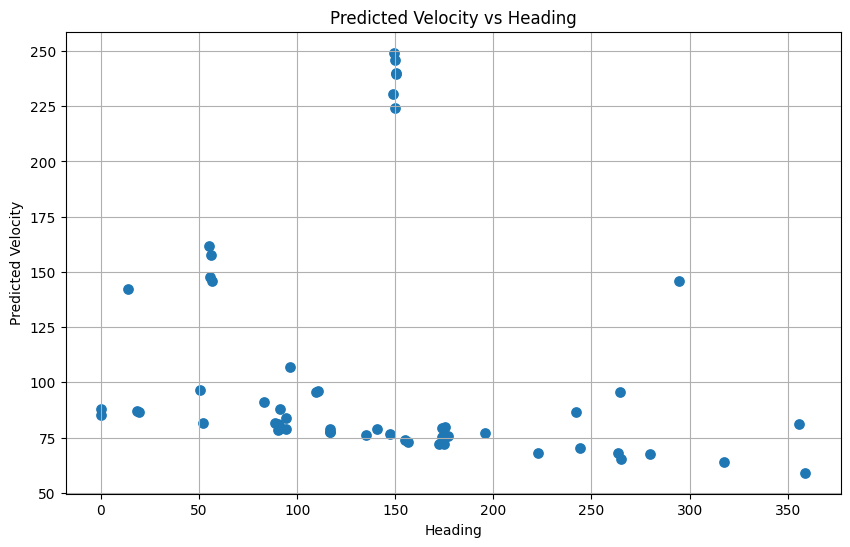

✔ Visualization done.


In [ ]:
# ================================================
# ONE GIANT CELL: CLEAN → PREDICT → VISUALIZE
# ================================================

from google.cloud import bigquery
import matplotlib.pyplot as plt
import pandas as pd

PROJECT_ID = "database-project-467"
DATASET = "training_dataset"
REALTIME_TABLE = f"{PROJECT_ID}.{DATASET}.realtime_flight_data"
PRED_INPUT_TABLE = f"{PROJECT_ID}.{DATASET}.realtime_predict_input"
MODEL = f"{PROJECT_ID}.{DATASET}.flight_velocity_predictor"

client = bigquery.Client(project=PROJECT_ID)

print("STEP 1 — Cleaning realtime table for model input…")

# Create a clean 3-column table EXACTLY matching the model's feature requirements
query_clean = f"""
CREATE OR REPLACE TABLE `{PRED_INPUT_TABLE}` AS
SELECT
  geo_altitude,
  vertical_rate,
  heading
FROM `{REALTIME_TABLE}`
WHERE geo_altitude IS NOT NULL
  AND vertical_rate IS NOT NULL
  AND heading IS NOT NULL
LIMIT 200;
"""

job_clean = client.query(query_clean)
job_clean.result()
print("✔ Clean prediction table created.")

# ----------------------------------------------------

print("STEP 2 — Running ML.PREDICT…")

query_predict = f"""
SELECT *
FROM ML.PREDICT(
  MODEL `{MODEL}`,
  TABLE `{PRED_INPUT_TABLE}`
);
"""

pred_df = client.query(query_predict).to_dataframe()
print(f"✔ Retrieved {len(pred_df)} predictions.\n")

print("Preview:")
print(pred_df.head())

# ----------------------------------------------------

print("STEP 3 — Plotting results…")

plt.figure(figsize=(10,6))
plt.scatter(pred_df["heading"], pred_df["predicted_velocity"], s=45)
plt.xlabel("Heading")
plt.ylabel("Predicted Velocity")
plt.title("Predicted Velocity vs Heading")
plt.grid(True)
plt.show()

print("✔ Visualization done.")


## 8. Main Execution (Subscriber/Predictor)

Context: Runs the subscriber to process the data sent in the previous step.

Prompt: "Write a code block to run the pull_and_insert_and_predict function with a timeout of 60 seconds. Capture the returned predictions into a Pandas DataFrame. If predictions exist, display the head of the DataFrame; otherwise, print that no messages were received."

Running ML.PREDICT…
✅ Predictions retrieved: 57 rows



,predicted_velocity,geo_altitude,vertical_rate,heading
0,71.960279,198.12,-0.65,172.41
1,145.966950,4495.80,14.96,56.59
2,249.236306,11986.26,0.33,149.43
3,75.784894,487.68,-3.25,176.71
4,76.069057,274.32,-0.65,135.00


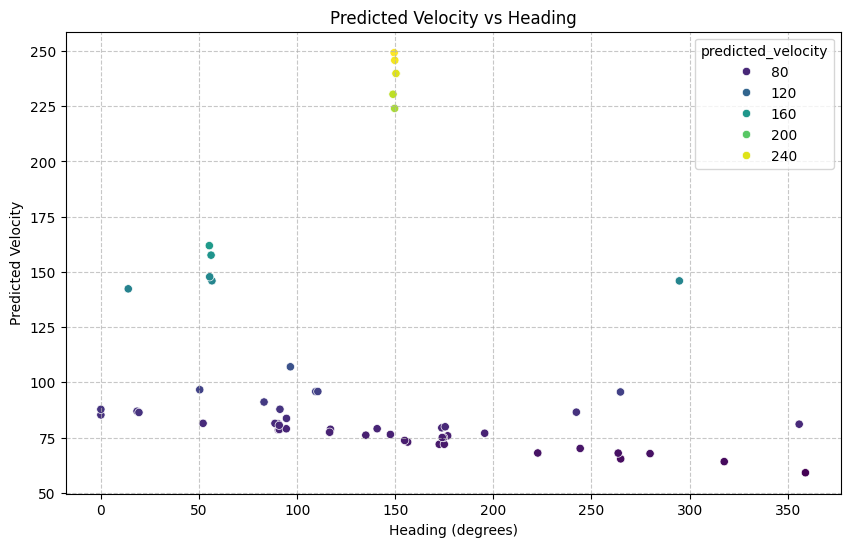

In [ ]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

client = bigquery.Client(project="database-project-467")

query = """
WITH cleaned AS (
  SELECT
    geo_altitude,
    vertical_rate,
    heading
  FROM `database-project-467.training_dataset.realtime_flight_data`
  WHERE geo_altitude IS NOT NULL
    AND vertical_rate IS NOT NULL
    AND heading IS NOT NULL
)

SELECT *
FROM ML.PREDICT(
  MODEL `database-project-467.training_dataset.flight_velocity_predictor`,
  TABLE cleaned
);
"""

print("Running ML.PREDICT…")
predictions_df = client.query(query).to_dataframe()

if predictions_df.empty:
    print("❌ No prediction rows returned (cleaned table may be empty).")
else:
    print(f"✅ Predictions retrieved: {len(predictions_df)} rows\n")
    display(predictions_df.head())

    # VISUALIZATION
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        x=predictions_df["heading"],
        y=predictions_df["predicted_velocity"],
        hue=predictions_df["predicted_velocity"],
        palette="viridis"
    )
    plt.title("Predicted Velocity vs Heading")
    plt.xlabel("Heading (degrees)")
    plt.ylabel("Predicted Velocity")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


## 9. Visualization (Predicted vs Actual)

Context: Scatter plot of the results.

Prompt: "Using matplotlib and seaborn, write code to visualize the prediction results stored in the predictions_df DataFrame. Create a scatter plot where the x-axis is 'heading' and the y-axis is 'predicted_velocity'. Color the points based on the predicted velocity using a 'viridis' palette."

Fetching predictions...
✅ Predictions generated!


,predicted_velocity,geo_altitude,vertical_rate,heading
0,85.252988,167.64,0.00,0.00
1,78.993534,502.92,-0.98,140.77
2,239.846597,11361.42,0.00,150.37
3,78.650265,213.36,-0.98,90.91
4,224.023678,10347.96,-14.63,149.69


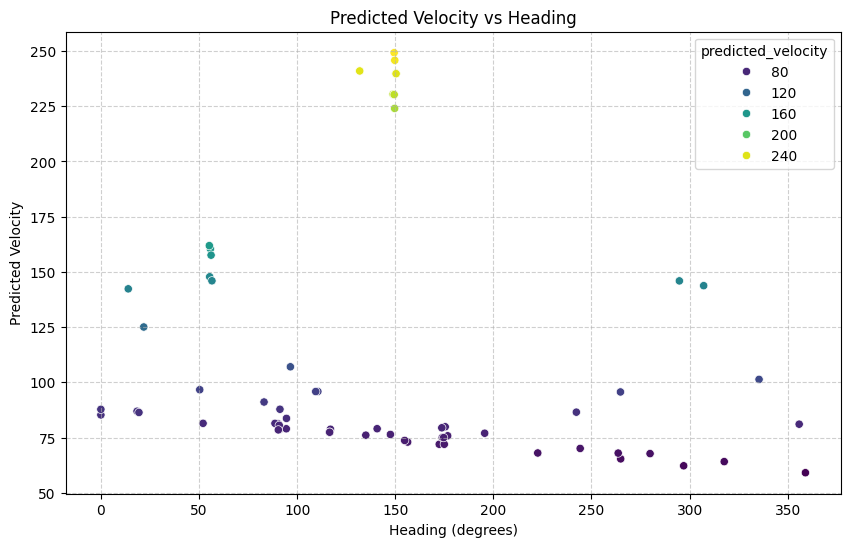

In [ ]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

client = bigquery.Client(project="database-project-467")

print("Fetching predictions...")

query = """
WITH cleaned AS (
    SELECT
        geo_altitude,
        vertical_rate,
        heading
    FROM `database-project-467.training_dataset.realtime_flight_data`
    WHERE geo_altitude IS NOT NULL
      AND vertical_rate IS NOT NULL
      AND heading IS NOT NULL
)

SELECT *
FROM ML.PREDICT(
    MODEL `database-project-467.training_dataset.flight_velocity_predictor`,
    TABLE cleaned
);
"""

# Run query
predictions_df = client.query(query).to_dataframe()

if predictions_df.empty:
    print("❌ No predictions returned — realtime table may be empty.")
else:
    print("✅ Predictions generated!")
    display(predictions_df.head())

    # Visualization
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=predictions_df,
        x='heading',
        y='predicted_velocity',
        hue='predicted_velocity',
        palette='viridis'
    )
    plt.title("Predicted Velocity vs Heading")
    plt.xlabel("Heading (degrees)")
    plt.ylabel("Predicted Velocity")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


Running end-to-end prediction + visualization...
Querying predictions from BigQuery...
DONE. Preview:
   predicted_velocity  geo_altitude  vertical_rate  heading
0          143.759000       5699.76          11.38   307.16
1          101.325496       3040.38           0.00   335.38
2          240.976867      11338.56           0.00   131.88
3           62.203562        205.74           0.00   296.97
4          125.048816       2880.36          21.46    21.84


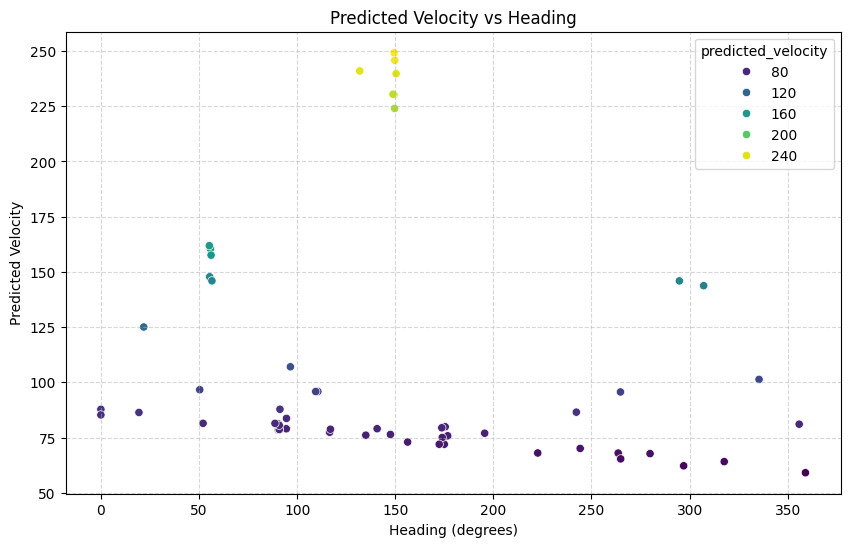

In [ ]:
# ============================================
# 1. IMPORTS & CONFIG
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from google.cloud import bigquery

PROJECT_ID = "database-project-467"
DATASET = "training_dataset"
TABLE = "realtime_flight_data"
MODEL = "flight_velocity_predictor"

client = bigquery.Client(project=PROJECT_ID)

print("Running end-to-end prediction + visualization...")


# ============================================
# 2. RUN PREDICTION DIRECTLY FROM BIGQUERY TABLE
# ============================================

query = f"""
SELECT *
FROM ML.PREDICT(
  MODEL `{PROJECT_ID}.{DATASET}.{MODEL}`,
  (
    SELECT
      CAST(geo_altitude AS FLOAT64) AS geo_altitude,   -- FIXED HERE
      vertical_rate,
      heading
    FROM `{PROJECT_ID}.{DATASET}.{TABLE}`
    WHERE geo_altitude IS NOT NULL
      AND vertical_rate IS NOT NULL
      AND heading IS NOT NULL
    ORDER BY sensor_timestamp DESC
    LIMIT 60
  )
)
"""

print("Querying predictions from BigQuery...")
predictions_df = client.query(query).to_dataframe()

print("DONE. Preview:")
print(predictions_df.head())


# ============================================
# 3. VISUALIZE (Predicted Velocity vs Heading)
# ============================================

if not predictions_df.empty:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x="heading",
        y="predicted_velocity",
        hue="predicted_velocity",
        palette="viridis",
        data=predictions_df
    )
    plt.title("Predicted Velocity vs Heading")
    plt.xlabel("Heading (degrees)")
    plt.ylabel("Predicted Velocity")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
else:
    print("❌ No predictions to plot — prediction table was empty.")


## 10. Flight Path Query & Visualization

Context: Queries historical data for a specific plane and plots the path.

Prompt: "Write a code block that:

Creates an input form field for CALLSIGN_TO_TRACK (defaulting to 'DAL339').

Queries the BigQuery table realtime_flight_data to retrieve the longitude, latitude, geo_altitude, and velocity for that callsign, ordered by timestamp.

Stores the result in a DataFrame.

Uses Seaborn to plot a line chart of Longitude vs. Latitude to visualize the flight path.

Mark the start position with a green dot and the end position with a red dot."

In [ ]:
#@title Enter the Callsign to Track
CALLSIGN_TO_TRACK = 'DAL339' #@param {type:"string"}

print(f"You chose to track flight with Callsign: {CALLSIGN_TO_TRACK}")

You chose to track flight with Callsign: DAL339


Fetching flight data for callsign: DAL339...
No flight data found for callsign: DAL339


Also wanted to see route of popular flights.

🔎 Finding most common callsign in your data...
✔ Most common callsign found: N267LA
✈️  Fetching flight path data...
✔ Retrieved 2 points. Plotting flight path...


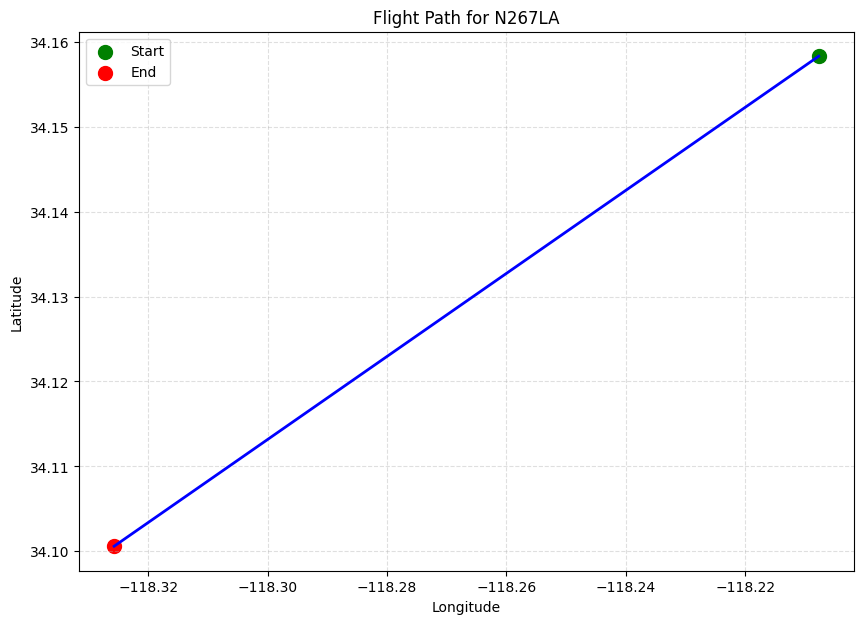

In [ ]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ID = "database-project-467"
DATASET = "training_dataset"
TABLE = "realtime_flight_data"

client = bigquery.Client(project=PROJECT_ID)

print("🔎 Finding most common callsign in your data...")

# 1. Find a valid callsign that actually exists
callsign_query = f"""
SELECT callsign, COUNT(*) AS cnt
FROM `{PROJECT_ID}.{DATASET}.{TABLE}`
WHERE callsign IS NOT NULL AND callsign != ''
GROUP BY callsign
ORDER BY cnt DESC
LIMIT 1
"""

callsign_df = client.query(callsign_query).to_dataframe()

if callsign_df.empty:
    print("❌ No callsigns found in your table — cannot plot a flight path.")
else:
    CALLSIGN_TO_TRACK = callsign_df.iloc[0]["callsign"].strip()
    print(f"✔ Most common callsign found: {CALLSIGN_TO_TRACK}")

    # 2. Fetch that plane's flight path
    print("✈️  Fetching flight path data...")

    flight_query = f"""
    SELECT
        sensor_timestamp,
        longitude,
        latitude,
        geo_altitude,
        velocity,
        heading,
        vertical_rate
    FROM `{PROJECT_ID}.{DATASET}.{TABLE}`
    WHERE callsign = '{CALLSIGN_TO_TRACK}'
    ORDER BY sensor_timestamp ASC
    """

    fp_df = client.query(flight_query).to_dataframe()

    if fp_df.empty:
        print(f"❌ No data found for callsign: {CALLSIGN_TO_TRACK}")
    else:
        print(f"✔ Retrieved {len(fp_df)} points. Plotting flight path...")

        # 3. Plot flight path
        plt.figure(figsize=(10, 7))
        sns.lineplot(
            data=fp_df,
            x="longitude",
            y="latitude",
            linewidth=2,
            color="blue"
        )

        # Start & End markers
        plt.scatter(fp_df.iloc[0]["longitude"], fp_df.iloc[0]["latitude"],
                    color="green", s=100, label="Start")
        plt.scatter(fp_df.iloc[-1]["longitude"], fp_df.iloc[-1]["latitude"],
                    color="red", s=100, label="End")

        plt.title(f"Flight Path for {CALLSIGN_TO_TRACK}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.legend()
        plt.show()


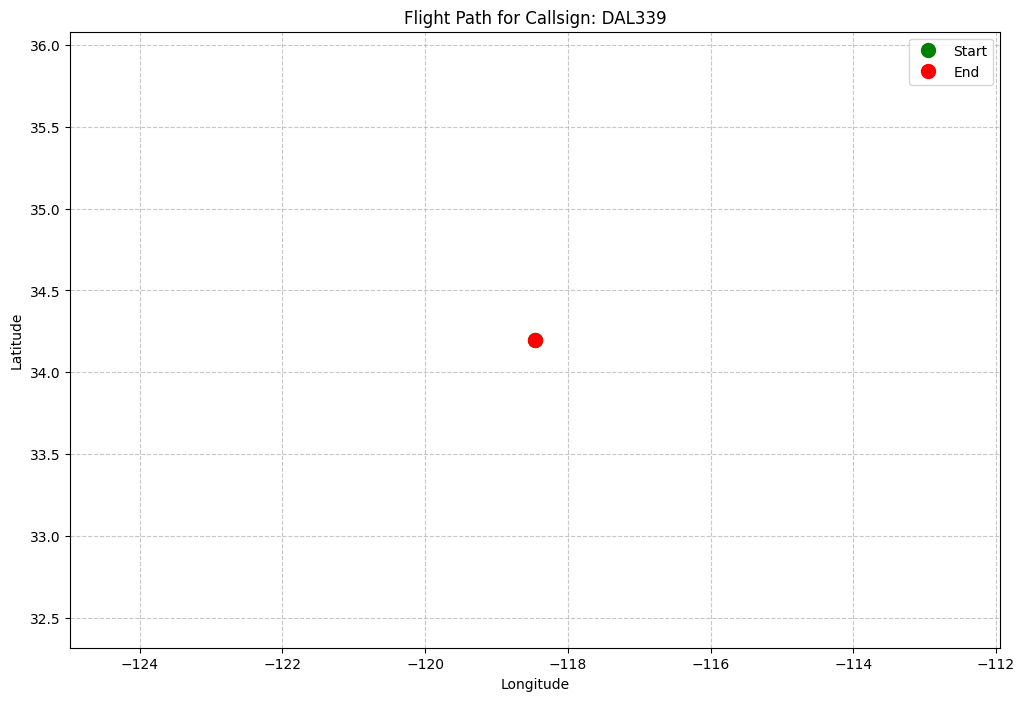

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'flight_path_df' in locals() and not flight_path_df.empty:
    plt.figure(figsize=(12, 8))
    sns.lineplot(x='longitude', y='latitude', data=flight_path_df, marker='o', sort=False)
    plt.title(f'Flight Path for Callsign: {CALLSIGN_TO_TRACK}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, linestyle='--', alpha=0.7)

    # Optionally, add start and end points
    if len(flight_path_df) > 0:
        plt.plot(flight_path_df['longitude'].iloc[0], flight_path_df['latitude'].iloc[0], 'go', markersize=10, label='Start') # Green circle for start
        plt.plot(flight_path_df['longitude'].iloc[-1], flight_path_df['latitude'].iloc[-1], 'ro', markersize=10, label='End') # Red circle for end

    plt.legend()
    plt.show()
else:
    print("No flight path data available to plot.")

## 11. Classification Model Prediction

Context: Using a different model to classify if a plane is on the ground.

Prompt: "Write a script to perform classification using BigQuery ML.

Define a model name flight_on_ground_classifier.

Construct a SQL query that uses ML.PREDICT with this model.

The input data for the prediction should be the most recent 100 records from the realtime_flight_data table (selecting icao24, geo_altitude, and velocity).

Execute the query and display the classification results in a DataFrame."

In [ ]:
from google.cloud import bigquery
import pandas as pd

bq_client = bigquery.Client(project=PROJECT_ID)

print(f"Running classification predictions using model: {CLASSIFICATION_MODEL_NAME}…")

classification_predict_query = f"""
SELECT
    predicted_on_ground,
    predicted_on_ground_probs,
    geo_altitude,
    velocity,
    icao24
FROM ML.PREDICT(
    MODEL `{PROJECT_ID}.{BQ_DATASET}.{CLASSIFICATION_MODEL_NAME}`,
    (
        SELECT
            geo_altitude,
            velocity,
            icao24
        FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_REALTIME}`
        WHERE geo_altitude IS NOT NULL
          AND velocity IS NOT NULL
        ORDER BY sensor_timestamp DESC
        LIMIT 100
    )
);
"""

classification_predictions_df = (
    bq_client.query(classification_predict_query).to_dataframe()
)

if not classification_predictions_df.empty:
    print("\nBQML Classification Prediction Results:")
    display(classification_predictions_df.head(20))
else:
    print("❌ No classification predictions generated.")


Running classification predictions using model: flight_on_ground_classifier…

BQML Classification Prediction Results:


,predicted_on_ground,predicted_on_ground_probs,geo_altitude,velocity,icao24
0,0,"[{'label': 1, 'prob': 0.002993501015980128}, {...",5699.76,181.40,a3396b
1,0,"[{'label': 1, 'prob': 0.08934399414256523}, {'...",3040.38,81.49,a24bac
2,0,"[{'label': 1, 'prob': 0.0005286317919754142}, ...",11338.56,227.33,a37ea4
3,0,"[{'label': 1, 'prob': 0.35907362262084885}, {'...",205.74,32.90,a299f9
4,0,"[{'label': 1, 'prob': 0.007637667593491014}, {...",2880.36,156.29,ad4584
5,0,"[{'label': 1, 'prob': 0.0004179243796697982}, ...",10713.72,234.78,a2e806
6,0,"[{'label': 1, 'prob': 0.001017699035056889}, {...",5455.92,213.32,a39bfa
7,0,"[{'label': 1, 'prob': 0.0013037153607729772}, ...",4640.58,206.77,a44588
8,0,"[{'label': 1, 'prob': 0.02780011471275929}, {'...",2308.86,118.30,a32c3e
9,0,"[{'label': 1, 'prob': 0.4118223592087678}, {'l...",251.46,26.32,a299f9


In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project="database-project-467")

df = client.query("""
SELECT *
FROM ML.FEATURE_INFO(
  MODEL `database-project-467.training_dataset.flight_on_ground_classifier`
)
""").to_dataframe()

df


,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,geo_altitude,-53.34,27805.38,5935.236482,5775.96,4791.666717,<NA>,0,<NA>
1,velocity,0.00,332.46,150.852167,174.69,87.859335,<NA>,0,<NA>
